In [1]:
'''
Case study for paper: reflected RFI
'''


import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
from contextlib import contextmanager
import xarray as xr
import importlib

@contextmanager
def cd(newdir):
    prevdir = os.getcwd()
    os.chdir(newdir)
    try:
        yield
    finally:
        os.chdir(prevdir)

rfi_file = '/pdata4/archive/GPM/1CR_GMI_V7/1408/140806/1C-R.GPM.GMI.XCAL2016-C.20140806-S121155-E134428.002487.V07A.HDF5'

model_path = '/edata2/spencer/rfi_prediction/GMI/GPM'
with cd(model_path):
    import local_functions
    import model_operations
    import sensor_info
    importlib.reload(local_functions)
    importlib.reload(model_operations)
    importlib.reload(sensor_info)
    #mlflag = model_operations.ml_quality_control(rfi_file, error_threshold=7)
    data = local_functions.read_gmi_l1c(rfi_file)
    nscans, npixs = data['lat'].shape
    #mlflag = mlflag.reshape(nscans,npixs,-1)
    
#print(np.sum(mlflag > 0., axis=0))
#print(sensor_info.channel_descriptions)
all_chans = sensor_info.channel_descriptions

lat = data['lat']
lon = data['lon']
qual = data['qual'][:,:,0]

In [42]:
def get_prediction_error(lat, lon, Tbs, scantime, modelpath, sensor):
    
    good = ~np.isnan(lat)

    nscans, npixs, nchans = Tbs.shape
    scantime = local_functions.copy_columns(scantime, npixs)

    with cd(modelpath):
        #Load in model tree
        model_tree = model_operations.load_model_tree()
        #Attach GPM surface type
        sfctype = np.zeros([nscans,npixs], dtype=np.int32)
        sfctype[:] = -99
        sfctype[good] = local_functions.attach_gpm_sfctype(lat[good], 
                                                           lon[good],
                                                           scantime[good], 
                                                           sensor=sensor)
        #Do Tb prediction
        Tbs_pred = np.zeros_like(Tbs)
        Tbs_pred[:] = np.nan
        Tbs_pred[good] = model_operations.run_predictions(Tbs[good], 
                                                          sfctype[good], 
                                                          model_tree, 
                                                          keep_dims=False)

        #Load in stats files
        mean_ocn = np.fromfile('mean_ocn.arr', sep='', dtype=np.float32)
        std_ocn  = np.fromfile('std_ocn.arr', sep='', dtype=np.float32)
        mean_non = np.fromfile('mean_non.arr', sep='', dtype=np.float32)
        std_non  = np.fromfile('std_non.arr', sep='', dtype=np.float32)

    #Preallocate error array
    epsilon_hat = np.zeros_like(Tbs_pred)
    epsilon_hat[:] = np.nan

    #Separate by surface type
    ocean = sfctype == 1
    ocean = ocean.reshape(nscans,npixs)
    nonocean = sfctype > 1
    nonocean = nonocean.reshape(nscans,npixs)

    #Get error
    epsilon = Tbs - Tbs_pred
    #Standardize error
    epsilon_hat[ocean] = np.abs(epsilon[ocean] - mean_ocn) / std_ocn
    epsilon_hat[nonocean] = np.abs(epsilon[nonocean] - mean_non) / std_non
    
    return epsilon_hat

pred_err = get_prediction_error(
    data['lat'], data['lon'], data['Tbs'], data['scantime'],
    model_path, 'GMI'
)


In [43]:
error_threshold = 5
mlflag = np.zeros_like(data['Tbs'], dtype=np.int32)
mlflag[pred_err > error_threshold] = 1
mlflag[np.isnan(pred_err)] = -2

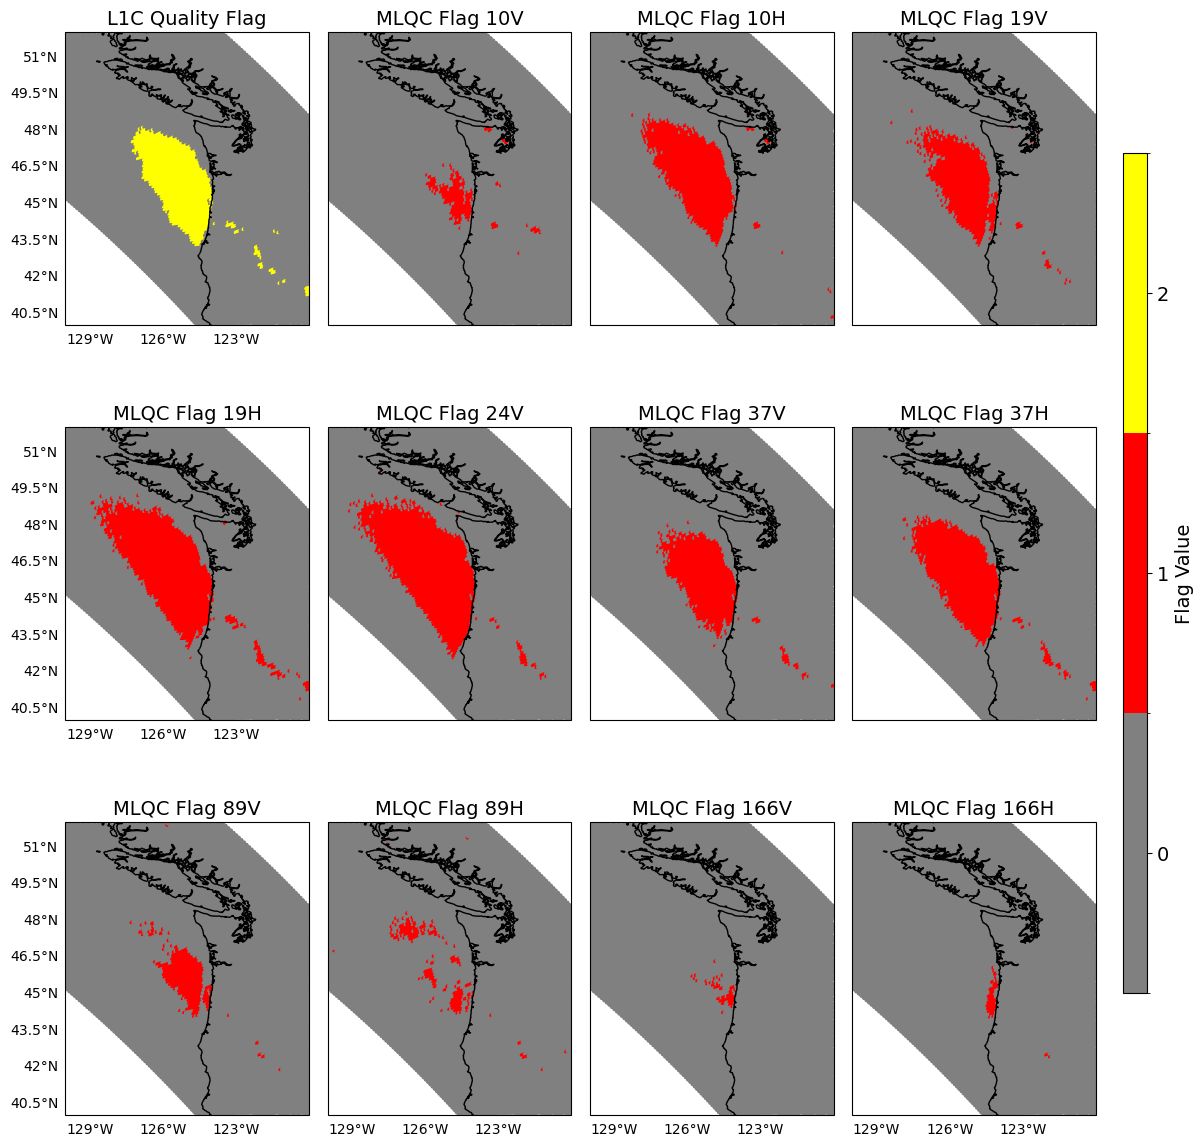

In [44]:

from matplotlib.colors import ListedColormap, BoundaryNorm

extent = [-130, -120, 40, 52]

within_lat_bounds = np.logical_and(lat <= extent[3], lat >= extent[2])
within_lon_bounds = np.logical_and(lon <= extent[1], lon >= extent[0])
within_bounds = np.logical_and(within_lat_bounds, within_lon_bounds)

# Define your custom colors
colors = {
     0: 'grey',
     1: 'red',
     2: 'yellow'
}

# Build discrete colormap and normalization
vals = list(colors.keys())
cmap = ListedColormap([colors[v] for v in vals])
norm = BoundaryNorm([v - 0.5 for v in vals] + [vals[-1] + 0.5], cmap.N)

# Create figure with 2 rows × 3 columns
fig, axes = plt.subplots(3, 4, figsize=(12, 12),
                         subplot_kw={'projection': ccrs.PlateCarree()})

axes = axes.flatten()

# Example plots — update variable indices to your actual data
im1 = axes[0].scatter(lon[within_bounds], lat[within_bounds], c=qual[within_bounds],
                      transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, s=4)
axes[0].set_title(f'L1C Quality Flag', fontsize=14)

for i in range(11):
    axes[i+1].scatter(lon[within_bounds],lat[within_bounds],c=mlflag[within_bounds,i],
                     transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, s=4)
    axes[i+1].set_title(f'MLQC Flag {sensor_info.feature_descriptions[i]}', fontsize=14)

for i,ax in enumerate(axes):
    ax.coastlines()
    ax.set_extent(extent)
    gl = ax.gridlines(draw_labels=True, linewidth=0.8, color='gray', alpha=0., linestyle='--')
    
    if i == 0 or i == 4 or i == 8:
        gl.top_labels = False
        gl.right_labels = False
    elif i == 12:
        gl.top_labels = False
        gl.right_labels = False
    elif i == 9 or i == 10 or i == 11:
        gl.left_labels = False
        gl.top_labels = False
        gl.right_labels = False   
    else:
        gl.left_labels = False
        gl.right_labels = False
        gl.top_labels = False
        gl.bottom_labels = False

# Adjust layout for colorbar space
plt.tight_layout(rect=[0, 0, 0.93, 1])

# Shared colorbar on far right
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cb = fig.colorbar(im1, cax=cbar_ax, ticks=vals)
cb.ax.tick_params(labelsize=14)
cb.set_label('Flag Value', fontsize=14)

plt.show()



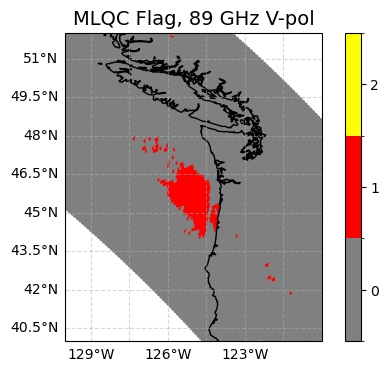

In [48]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())


cmap = ListedColormap([colors[v] for v in vals])
norm = BoundaryNorm([v - 0.5 for v in vals] + [vals[-1] + 0.5], cmap.N)

im = ax.scatter(lon[within_bounds],lat[within_bounds],c=mlflag[within_bounds,7],
                     transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, s=5)



ax.set_extent(extent)
ax.coastlines()
ax.set_title('MLQC Flag, 89 GHz V-pol', fontsize=14)
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cbar = plt.colorbar(im, ticks=vals)
plt.show()


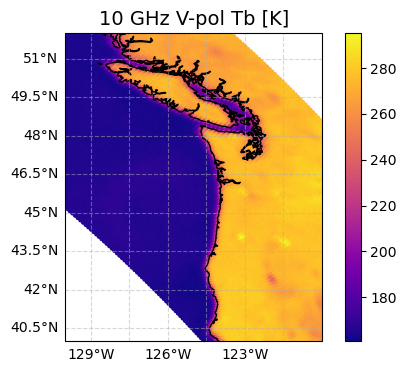

In [39]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

im = ax.scatter(lon[within_bounds],lat[within_bounds],c=data['Tbs'][within_bounds,0],
                     transform=ccrs.PlateCarree(), cmap='plasma', s=5)



ax.set_extent(extent)
ax.coastlines()
ax.set_title('10 GHz V-pol Tb [K]', fontsize=14)
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cbar = plt.colorbar(im)
plt.show()


In [49]:


model_path = '/edata2/spencer/rfi_prediction/GMI/GPM_no19'

with cd(model_path):
    importlib.reload(sensor_info)
    importlib.reload(local_functions)
    importlib.reload(model_operations)
    #mlflag = model_operations.ml_quality_control(rfi_file, error_threshold=7)
    data = local_functions.read_gmi_l1c(rfi_file)
    nscans, npixs = data['lat'].shape
    #mlflag = mlflag.reshape(nscans,npixs,-1)
    
#print(np.sum(mlflag > 0., axis=0))
#print(sensor_info.channel_descriptions)


In [50]:
pred_err = get_prediction_error(
    data['lat'], data['lon'], data['Tbs'], data['scantime'],
    model_path, 'GMI'
)

In [51]:
error_threshold = 5
mlflag = np.zeros_like(data['Tbs'], dtype=np.int32)
mlflag[pred_err > error_threshold] = 1
mlflag[np.isnan(pred_err)] = -2

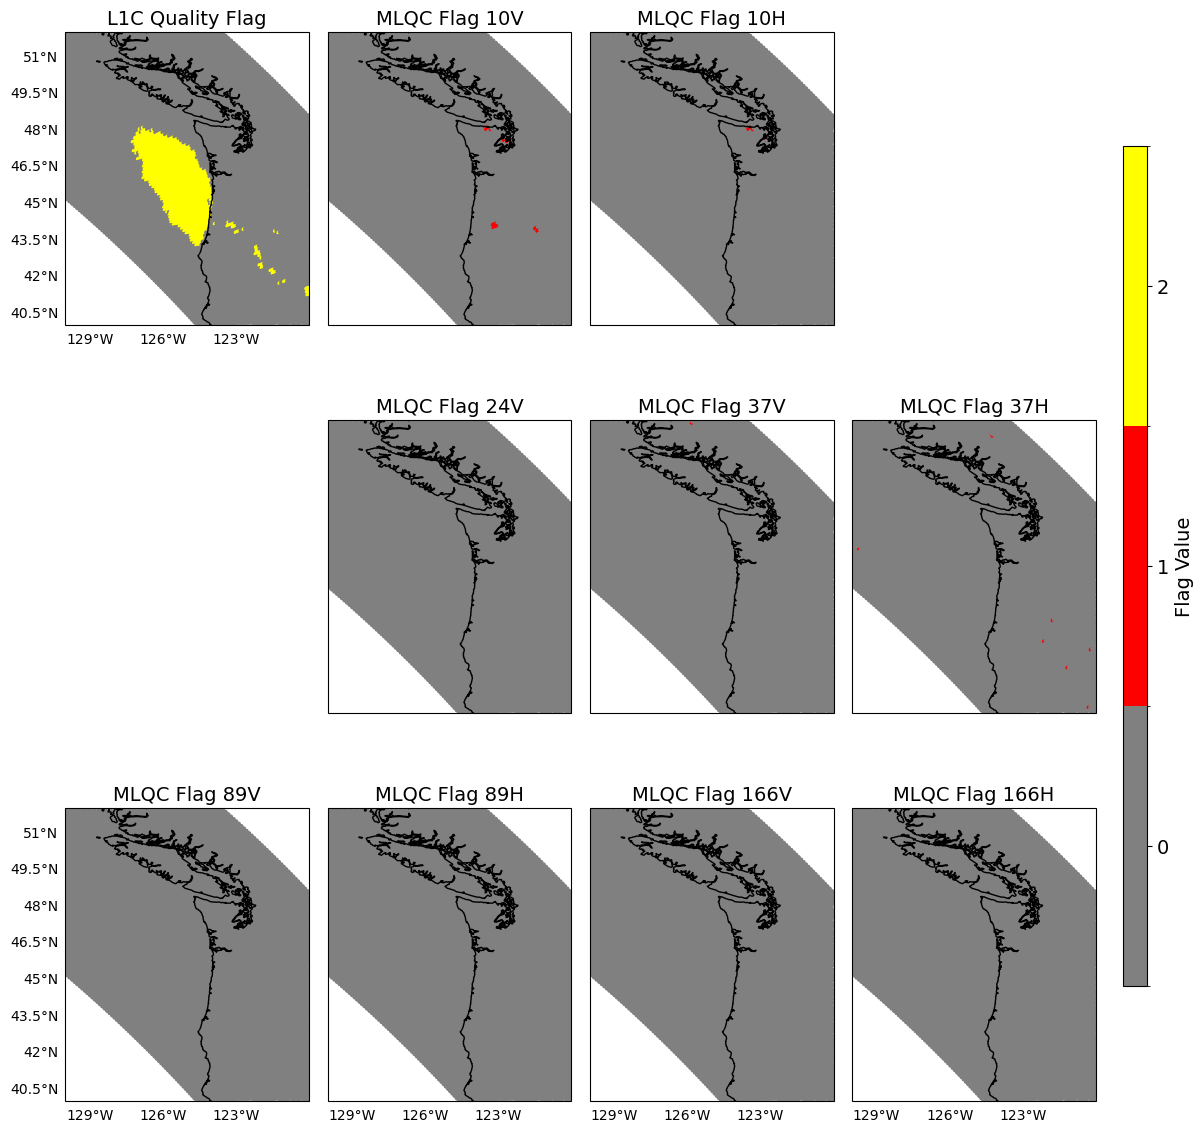

In [52]:

from matplotlib.colors import ListedColormap, BoundaryNorm

extent = [-130, -120, 40, 52]

within_lat_bounds = np.logical_and(lat <= extent[3], lat >= extent[2])
within_lon_bounds = np.logical_and(lon <= extent[1], lon >= extent[0])
within_bounds = np.logical_and(within_lat_bounds, within_lon_bounds)

# Define your custom colors
colors = {
     0: 'grey',
     1: 'red',
     2: 'yellow'
}

# Build discrete colormap and normalization
vals = list(colors.keys())
cmap = ListedColormap([colors[v] for v in vals])
norm = BoundaryNorm([v - 0.5 for v in vals] + [vals[-1] + 0.5], cmap.N)

# Create figure with 2 rows × 3 columns
fig, axes = plt.subplots(3, 4, figsize=(12, 12),
                         subplot_kw={'projection': ccrs.PlateCarree()})

axes = axes.flatten()

# Example plots — update variable indices to your actual data
im1 = axes[0].scatter(lon[within_bounds], lat[within_bounds], c=qual[within_bounds],
                      transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, s=4)
axes[0].set_title(f'L1C Quality Flag', fontsize=14)

j = 0
for i in range(11):
    if i == 2 or i == 3:
        axes[i+1].axis('off')
        continue
    axes[i+1].scatter(lon[within_bounds],lat[within_bounds],c=mlflag[within_bounds,i],
                     transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, s=4)
    axes[i+1].set_title(f'MLQC Flag {sensor_info.feature_descriptions[j]}', fontsize=14)
    j += 1

for i,ax in enumerate(axes):
    if i == 3 or i == 4: 
        ax.axis('off')
        continue
    ax.coastlines()
    ax.set_extent(extent)
    gl = ax.gridlines(draw_labels=True, linewidth=0.8, color='gray', alpha=0, linestyle='--')
    
    if i == 0 or i == 4 or i == 8:
        gl.top_labels = False
        gl.right_labels = False
    elif i == 12:
        gl.top_labels = False
        gl.right_labels = False
    elif i == 9 or i == 10 or i == 11:
        gl.left_labels = False
        gl.top_labels = False
        gl.right_labels = False   
    else:
        gl.left_labels = False
        gl.right_labels = False
        gl.top_labels = False
        gl.bottom_labels = False

    


# # Add labels only to lower-left plot
# gl = axes[3].gridlines(draw_labels=True, linewidth=0.8, color='gray', alpha=0.6, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False

# Adjust layout for colorbar space
plt.tight_layout(rect=[0, 0, 0.93, 1])

# Shared colorbar on far right
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cb = fig.colorbar(im1, cax=cbar_ax, ticks=vals)
cb.ax.tick_params(labelsize=14)
cb.set_label('Flag Value', fontsize=14)

plt.show()



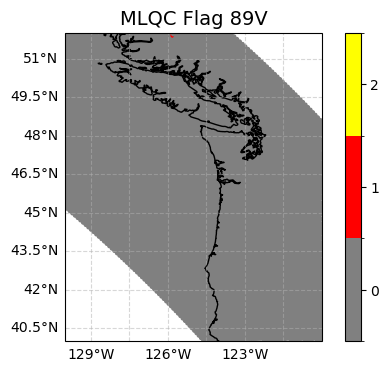

In [57]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())


cmap = ListedColormap([colors[v] for v in vals])
norm = BoundaryNorm([v - 0.5 for v in vals] + [vals[-1] + 0.5], cmap.N)

im = ax.scatter(lon[within_bounds],lat[within_bounds],c=mlflag[within_bounds,5],
                     transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, s=5)



ax.set_extent(extent)
ax.coastlines()
ax.set_title('MLQC Flag 89V', fontsize=14)
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cbar = plt.colorbar(im, ticks=vals)
plt.show()


In [6]:
with xr.open_dataset(rfi_file, group='S1', decode_timedelta=False) as f:
    lat = f.Latitude.values
    lon = f.Longitude.values

with xr.open_dataset(rfi_file, group='S1/SCstatus', decode_timedelta=False) as f:
    sclat = f.SClatitude.values
    sclon = f.SClongitude.values

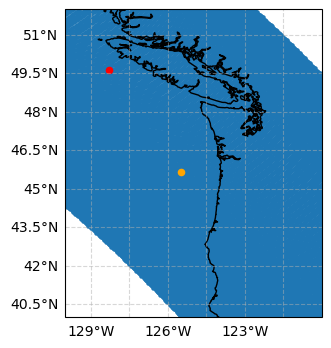

In [39]:
scan = 1752
pix = 90

extent = [-130, -120, 40, 52]

fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

im = ax.scatter(lon,lat,
                     transform=ccrs.PlateCarree(), s=5)

im = ax.scatter(lon[scan,pix],lat[scan,pix],
                     transform=ccrs.PlateCarree(), s=20, color='orange')

im = ax.scatter(sclon[scan], sclat[scan], 
                transform=ccrs.PlateCarree(), s=20, color='red')



ax.set_extent(extent)
ax.coastlines()
#ax.set_title('MLQC Flag 89V', fontsize=14)
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--')
gl.right_labels = False
gl.top_labels = False
#cbar = plt.colorbar(im)
plt.show()

In [38]:
sclat[scan], sclon[scan]

(np.float32(49.606075), np.float32(-128.28403))